# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

C:\conda\envs\history_matching\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 50

#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['08bb0d81-785f-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = int(re.search(r'iter(\d+)', os.getcwd()).group(1))

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 4
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_ea92219ca3800142bf0a022604e3255c.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.0,20.0,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.0,5.0,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.0,20.0,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.0,5.0,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Free_Interval_a,0.0,0.2,Scale_Factor_Free_Interval_a
Scale_Factor_Age_a,3.0,5.0,Scale_Factor_Age_a
Parasite_Density_Wave_Sigma,0.6,6.0,Parasite_Density_Wave_Sigma
Immune_Modifier_Include_Age,0.0,1.0,Immune_Modifier_Include_Age
Immune_Modifier_Include_Cumulative_Exposure,0.0,1.0,Immune_Modifier_Include_Cumulative_Exposure


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 08bb0d81-785f-ea11-a2c5-c4346bcb1550
08bb0d81-785f-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
44            0       2  15a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
107           0       6  19a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
170           0      55  3ca64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
233           0       7  1aa64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   
296           0      58  42a64d87-785f-ea11-a2c5-c4346bcb1550     W2        8   

     density_bin     value  
44            50  0.000000  
107           50  0.000000  
170           50  0.000000  
233           50  0.428746  
296           50  0.362313  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000000,13a64d87-785f-ea11-a2c5-c4346bcb1550,0.578231
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000001,14a64d87-785f-ea11-a2c5-c4346bcb1550,0.322163
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000002,15a64d87-785f-ea11-a2c5-c4346bcb1550,0.000000
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000003,16a64d87-785f-ea11-a2c5-c4346bcb1550,0.002249
08bb0d81-785f-ea11-a2c5-c4346bcb1550.000004,17a64d87-785f-ea11-a2c5-c4346bcb1550,0.524483


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, 2000000],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == 2000000]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


C:\conda\envs\history_matching\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\conda\envs\history_matching\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
186  PfPR by Parasitemia and Age Bin     W2     8.0        50    162.0   

     proportion  binomial error  
186    0.320988         0.03668  
Before logit, desired result is 0.321 [0.248, 0.394]: 


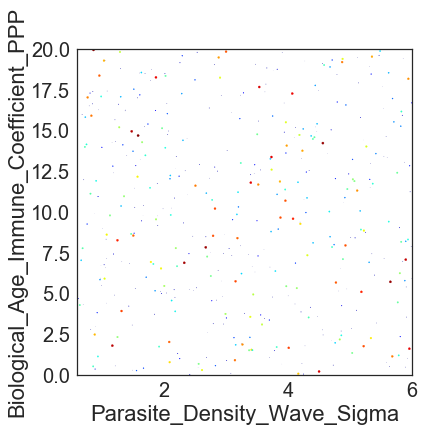

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 500 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 375 unique parameter configurations ( 375  simulations including replicates)
--> Testing  with 125  unique parameter configurations ( 125 simulations including replicates)


Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_TM')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Immune_Modifier_Include_Age')]),
 Term([EvalFactor('Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Immune_Modifier_Include_Recent_Exposure')]),
 Term([EvalFactor('Immune_Modifier_Include_Strain_Diversity')]),
 Term([EvalFactor('Immune_Modifier_Include_Malaria_Free_Interval')]),
 Term([EvalFactor('Immune_Modifier_Include_Age ** 2')]),
 Term([EvalFactor('Immune_Modifier_Include_Cumulative_Exposure ** 2')]),
 Term([EvalFactor('Cumulative_Exposure_Immune_Coefficient_PPP * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Immune_Modifier_Include_Age * Immune_Modifier_Include_Cumulative_Exposure')])]

Would you like to use this basis? [Y]/n: n
Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


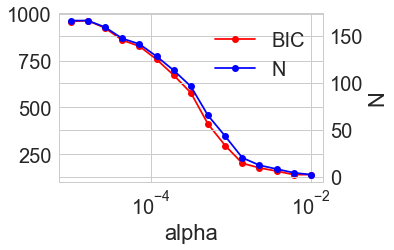

What would you like to use for the GLM regularization parameter, alpha_glm = 3e-3
User selected alpha = 0.003000
Non-Zero: 11 of 171
Regularization for GLM selected:
  * Intercept
 * Immune_Modifier_Include_Recent_Exposure
 * Immune_Modifier_Include_Strain_Diversity
 * Scale_Factor_Free_Interval_a ** 2
 * Immune_Modifier_Include_Recent_Exposure ** 2
 * Scale_Factor_Strain_Diversity_n ** 2
 * Cumulative_Exposure_Immune_Coefficient_TM * Immune_Modifier_Include_Cumulative_Exposure
 * Scale_Factor_Free_Interval_a * Immune_Modifier_Include_Malaria_Free_Interval
 * Immune_Modifier_Include_Malaria_Free_Interval * Diversity_From_Marginal_Prevalence
 * Scale_Factor_Strain_Diversity_n * Prevalence_Threshold_For_Diversity
 * Scale_Factor_Rec_Exp_midpoint * Diversity_From_Marginal_Prevalence


In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter1\Cuts\50_8_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Immune_Modifier_Include_Cumulative_Exposure',
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Cumulative_Exposure_Immune_Coefficient_PPP',
# 'Immune_Modifier_Include_Age',
# 'Biological_Age_Immune_Coefficient_TM',
# 'Biological_Age_Immune_Coefficient_PPP',
# 'Parasite_Density_Wave_Sigma'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Backing up gpr model to ..\iter1\Cuts\50_8_W2_Sugungum\GPR\model_2020_03_06_13_41_35.json
Fitting the GPR


KeyboardInterrupt: 

In [ ]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

In [ ]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [ ]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

In [ ]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [ ]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());